In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import peakutils
import logging
import datetime
import sys
import warnings
from lmfit.models import PseudoVoigtModel, GaussianModel
from jupyterthemes import jtplot
from matplotlib.colors import Normalize

In [2]:
sys.path.append('C:\\Users\\USUARIO\\Desktop\\xps_prog\\scripts')

In [3]:
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *
from xps.xps_fits import *

jtplot.style('grade3', context='talk', grid=False, ticks=True, fscale=1.5)
logging.getLogger().setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")

Atomic Sensibility Factors:

In [4]:
asf = dict({'C1s' : 0.296, 'O1s' : 0.711, 'O1s_sub' : 0.711, 'N1s' : 0.477, 'Ba3d' : 7.49, 'Ba_3d_5/2' : 7.49, 'Ba_3d_3/2' : 5.20,
            'Br_3p' : 1.054, 'Cu_2p' : 5.321, 'Ba4d': 2.35, 'Na1s' : 1.685, 'Cl_2s' : 0.37, 'Ru3d' : 4.273, 'Ru3p' : 1.53,
           'In3d' : 4.359, 'Sn3d' : 4.725, 'Cl2p' : 0.891, 'Cl2p_(2)' : 0.891, 'Cl2p_(3)' : 0.891, 'Si2p': 0.339, 'Si2s': 0.22})

asf2 = {'Ba_3d_5/2' : 25.8, 'Ba_3d_3/2': 17.9, 'Ba_4d': 5.86, 'Cl_2p': 2.28, 'Cl_2s': 1.69, }

asf3 = {'Ba_3d_5/2' : 64.3, 'Ba_3d_3/2': 49.9, 'Ba_4d': 5.86, 'Cl_2p': 2.28, 'Cl_2s': 1.50}
mfps = {'Cu2p' : 1.86, 'In3d': 3.05, 'Si2p': 3.8}

In [5]:
regss = ['O1s',  'N1s', 'C1s', 'Si2p','Si2s', 'In3d', 'Ba3d5/2', 'Cl2p', 'Ru3d5/2', 'Ru3p3/2', 'Ba4d',]
asfScof = {}
for r in regss:
    asfScof.update(search_asf(r))

Since we are not going to make a comparison between raw and processed data, we take the processed data directly. These have been done with scripts to have easy access to the processed data.

# Preprocess data

In [49]:
path = 'C:\\Users\\USUARIO\\Desktop\\xps_prog\\data\\quartz_G2SL\\2022_09_01_quartz_G2SL_subl_AYN06\\'

files = glob.glob(path+'/**/*.sxy')

#Organise files
files = files[::-1]
files = files[:-1]
files[1], files[2] = files[2], files[1]
files

['C:\\Users\\USUARIO\\Desktop\\xps_prog\\data\\quartz_G2SL\\2022_09_01_quartz_G2SL_subl_AYN06\\proc\\20220901_quartz_G2SL_AYN06_clean.sxy',
 'C:\\Users\\USUARIO\\Desktop\\xps_prog\\data\\quartz_G2SL\\2022_09_01_quartz_G2SL_subl_AYN06\\proc\\20220901_quartz_G2SL_AYN06_6h30min.sxy',
 'C:\\Users\\USUARIO\\Desktop\\xps_prog\\data\\quartz_G2SL\\2022_09_01_quartz_G2SL_subl_AYN06\\proc\\20220901_quartz_G2SL_AYN06_6h30min_BaCl2_90s.sxy']

In [7]:
experiments = [read_processed_xp(f) for f in files]

[Errno 2] No such file or directory: 'C:\\Users\\USUARIO\\Desktop\\Adelina\\xps_sw-master\\data\\quartz_G2SL\\2022_09_01_quartz_G2SL_subl_AYN06\\proc\\20220901_quartz_G2SL_AYN06_clean.sxy.ft', returning empty fit dict
[Errno 2] No such file or directory: 'C:\\Users\\USUARIO\\Desktop\\Adelina\\xps_sw-master\\data\\quartz_G2SL\\2022_09_01_quartz_G2SL_subl_AYN06\\proc\\20220901_quartz_G2SL_AYN06_6h30min.sxy.ft', returning empty fit dict
[Errno 2] No such file or directory: 'C:\\Users\\USUARIO\\Desktop\\Adelina\\xps_sw-master\\data\\quartz_G2SL\\2022_09_01_quartz_G2SL_subl_AYN06\\proc\\20220901_quartz_G2SL_AYN06_6h30min_BaCl2_90s.sxy.ft', returning empty fit dict


In [8]:
names = ['Quartz Clean','Quartz G2SL',  'Quartz G2SL $BaCl_2$']
cols = ['b', 'g', 'r']
for c, n, xp in zip (cols, names, experiments):
    xp.color = c
    xp.name = n

## Plot overview

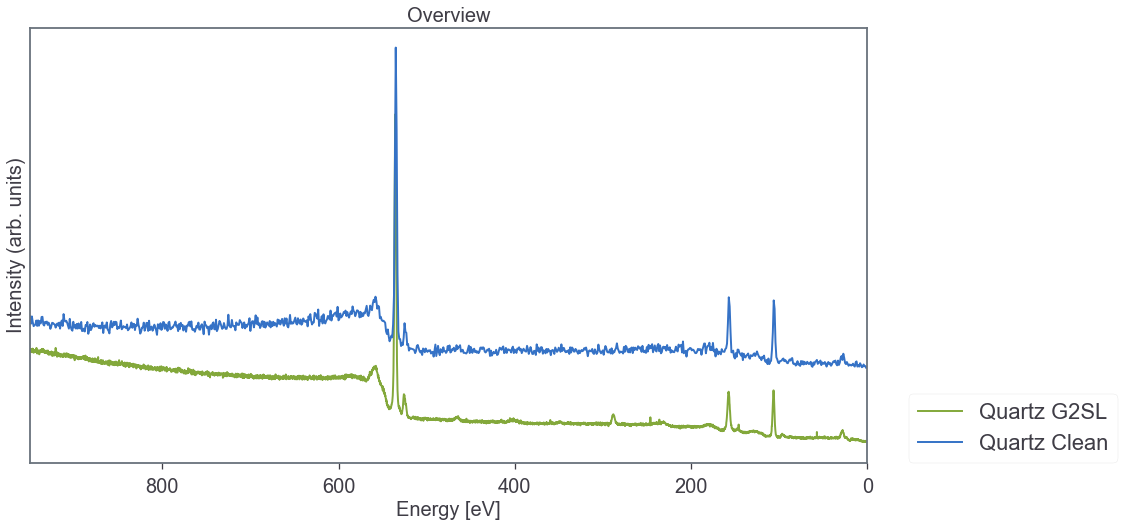

In [9]:
#Overview
plt.rcParams['axes.titlesize']=20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.fontsize']=22
plt.rcParams['xtick.labelsize'] = 20
plt.figure(figsize=(15,8))
for i,xp in enumerate(experiments[1::-1]):
    try:
        plot_region(xp, 'overview', offset=1600*i)
    except KeyError as e:
        print(e, 'in ', xp.name)
plt.gca().set(xlim = (950, 0))
plt.gca().set(title='Overview', ylabel='Intensity (arb. units)', yticks=[])
#plt.gca().invert_xaxis()
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

## Plot regions

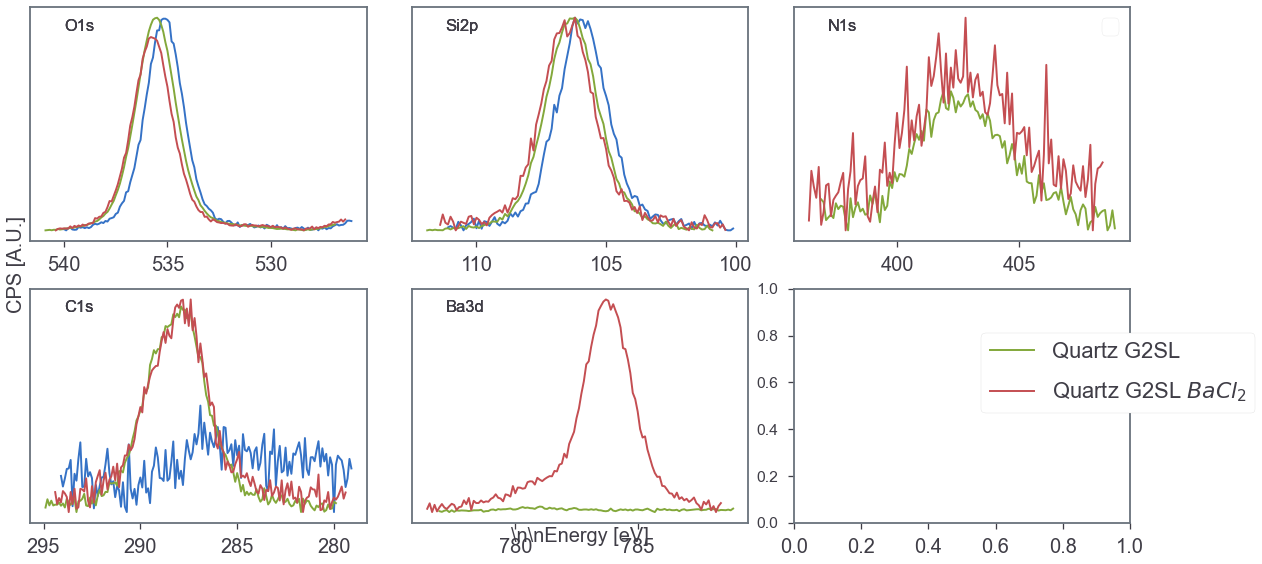

In [10]:
regs = [ 'O1s', 'Si2p', 'N1s', 'C1s', 'Ba3d']
plot_xp_regions(experiments, regs)
plt.legend()

## Rigid Shift Correction

It can be appreciated a shift in the different experiment

In [11]:
# Align the experiments
for xp in experiments: 
    shift = find_shift(xp, experiments[0], region='Si2p')
    align_dfx(xp,shift-0.4, inplace=True);

In [12]:
align_dfx(experiments[2], -0.2, inplace=True); #Error of -0.2 on Quartz G2SL BaCl2

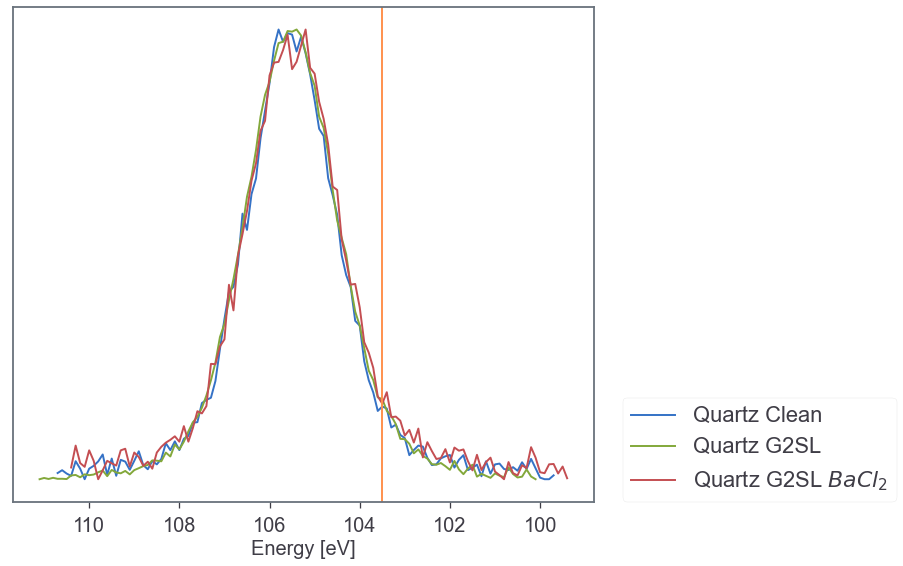

In [13]:
#Note the difference between the given maximum and the desired maximum.

for xp in experiments:
    plot_region(xp, 'Si2p')
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.gca().set(yticks=[], ylabel=None)
plt.axvline(x = 103.5, color = 'y', label = 'Theorical Si3d Peak in Quartz')
plt.show()

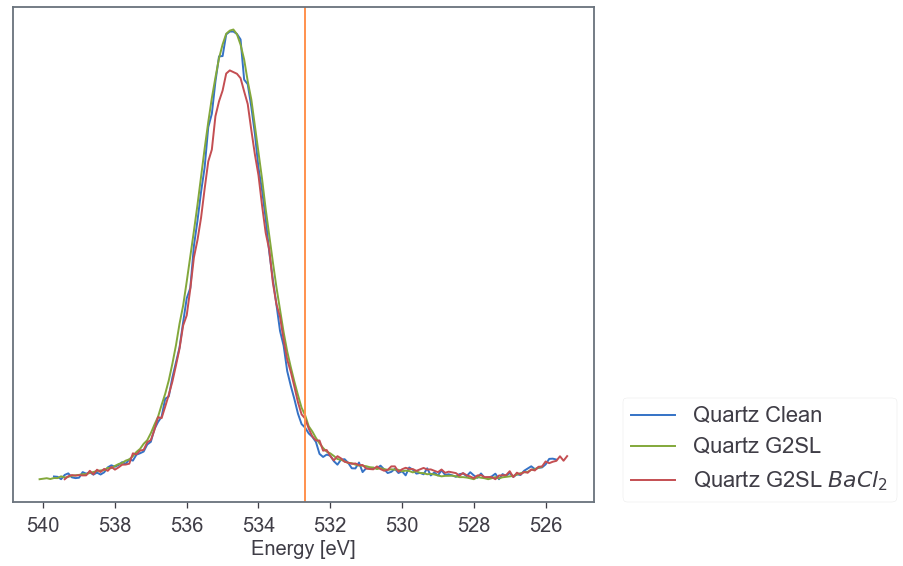

In [14]:
for xp in experiments:
    plot_region(xp, 'O1s')
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.gca().set(yticks=[], ylabel=None)
plt.axvline(x = 532.7, color = 'y', label = 'Theorical O1s Peak in Quartz')
plt.show()

In [15]:
# Correct Rigid Shift: -2.1
for xp in experiments: 
    align_dfx(xp,-2.1, inplace=True);

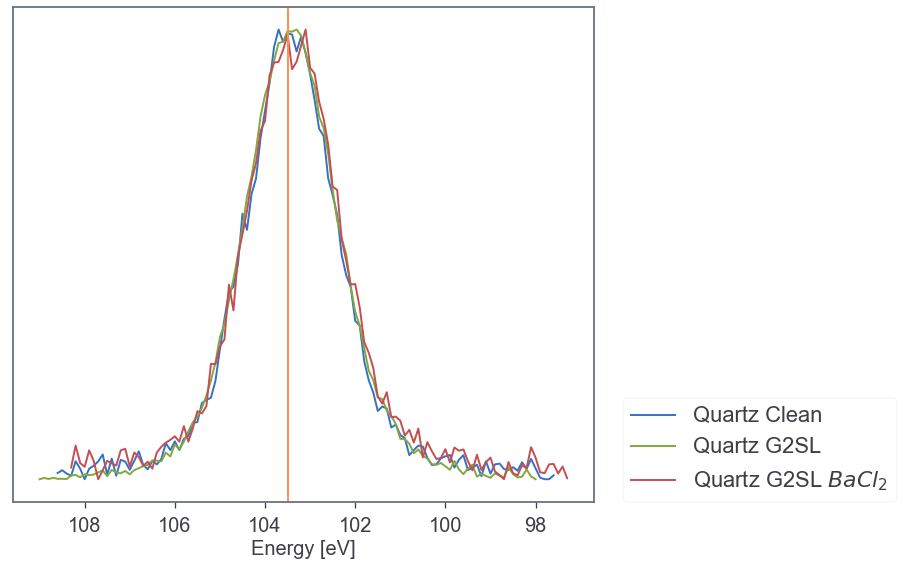

In [16]:
#Note the difference between the given maximum and the desired maximum.

for xp in experiments:
    plot_region(xp, 'Si2p')
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.gca().set(yticks=[], ylabel=None)
plt.axvline(x = 103.5, color = 'y', label = 'Theorical Si3d Peak in Quartz')
plt.show()

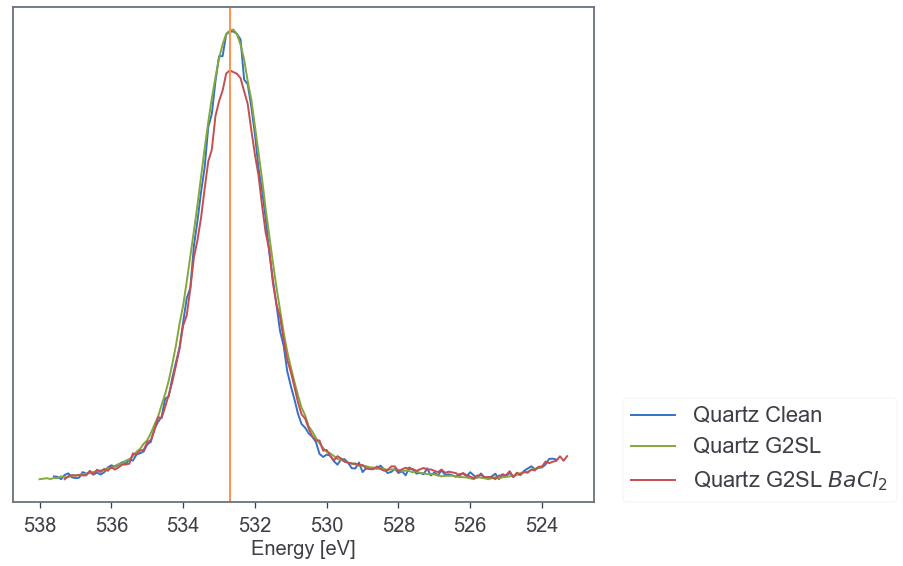

In [17]:
for xp in experiments:
    plot_region(xp, 'O1s')
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.gca().set(yticks=[], ylabel=None)
plt.axvline(x = 532.7, color = 'y', label = 'Theorical O1s Peak in Quartz')
plt.show()

# Stoichiometry

In [48]:
path = 'C:\\Users\\USUARIO\\Desktop\\xps_prog\\data\\quartz_G2SL\\2022_09_01_quartz_G2SL_subl_AYN06\\'
files = glob.glob(path+'**/*.uxy')

#Organise files
files = files[::-1]
files = files[:-1]
files[1],files[2]=files[2], files[1]
files

['C:\\Users\\USUARIO\\Desktop\\xps_prog\\data\\quartz_G2SL\\2022_09_01_quartz_G2SL_subl_AYN06\\proc\\20220901_quartz_G2SL_AYN06_clean.uxy',
 'C:\\Users\\USUARIO\\Desktop\\xps_prog\\data\\quartz_G2SL\\2022_09_01_quartz_G2SL_subl_AYN06\\proc\\20220901_quartz_G2SL_AYN06_6h30min.uxy',
 'C:\\Users\\USUARIO\\Desktop\\xps_prog\\data\\quartz_G2SL\\2022_09_01_quartz_G2SL_subl_AYN06\\proc\\20220901_quartz_G2SL_AYN06_6h30min_BaCl2_90s.uxy']

In [19]:
bg = [read_processed_xp(f) for f in files]

[Errno 2] No such file or directory: 'C:\\Users\\USUARIO\\Desktop\\Adelina\\xps_sw-master\\data\\quartz_G2SL\\2022_09_01_quartz_G2SL_subl_AYN06\\proc\\20220901_quartz_G2SL_AYN06_clean.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: 'C:\\Users\\USUARIO\\Desktop\\Adelina\\xps_sw-master\\data\\quartz_G2SL\\2022_09_01_quartz_G2SL_subl_AYN06\\proc\\20220901_quartz_G2SL_AYN06_6h30min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: 'C:\\Users\\USUARIO\\Desktop\\Adelina\\xps_sw-master\\data\\quartz_G2SL\\2022_09_01_quartz_G2SL_subl_AYN06\\proc\\20220901_quartz_G2SL_AYN06_6h30min_BaCl2_90s.uxy.ft', returning empty fit dict


'N1s' region does not exist in quartz_G2SL_AYN06_clean
'Ba3d' region does not exist in quartz_G2SL_AYN06_clean


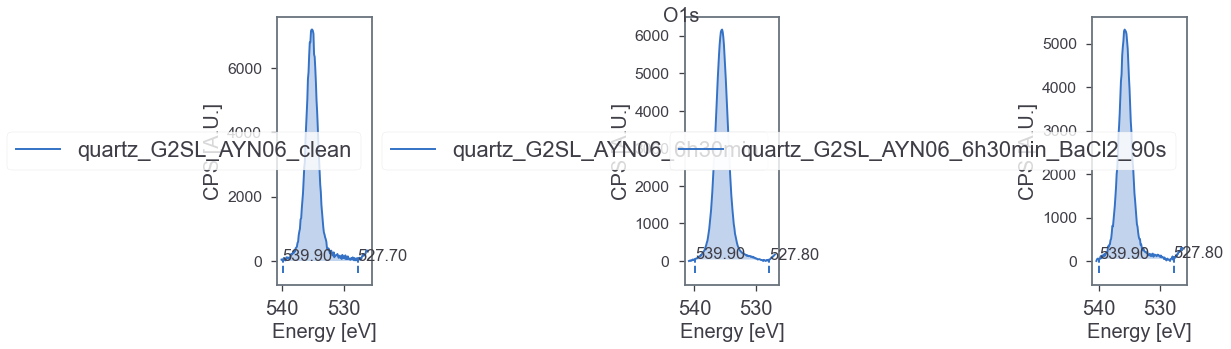

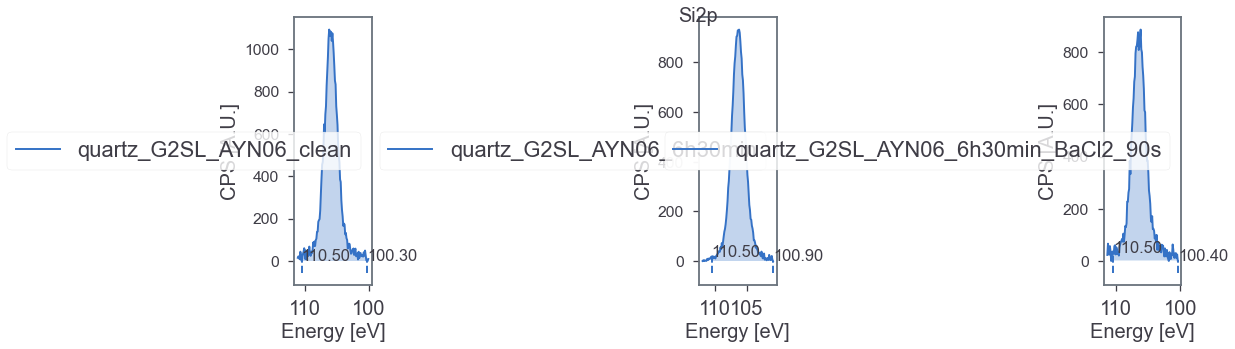

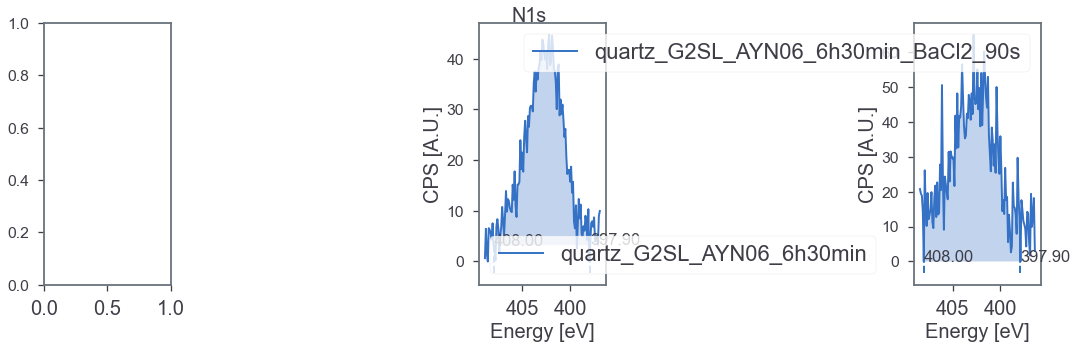

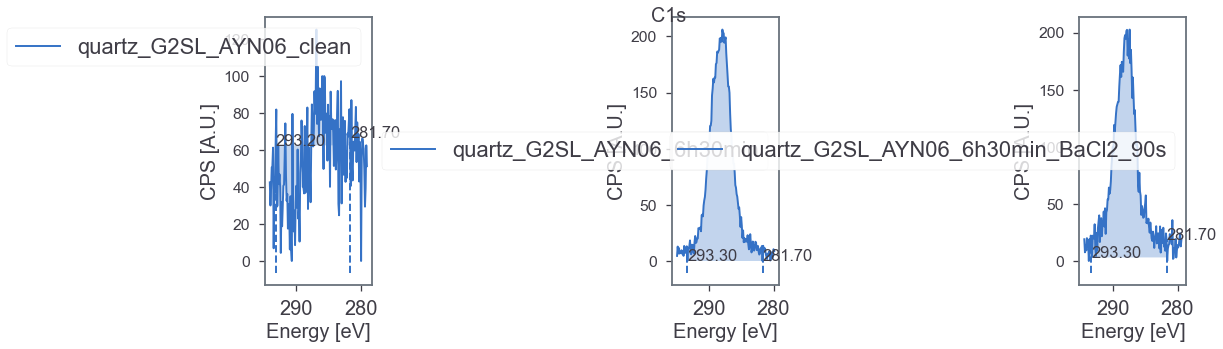

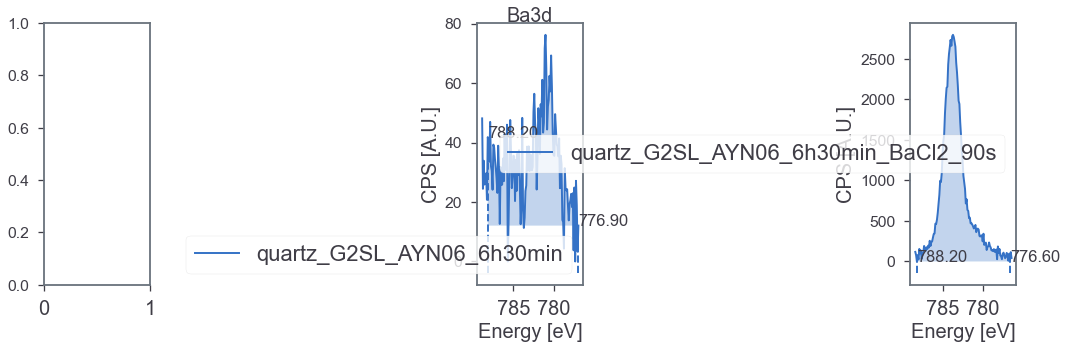

In [20]:
regs = ['O1s', 'Si2p', 'N1s', 'C1s', 'Ba3d']

for r in regs:
    integrateRegions(bg, r, asf=asf)

In [21]:
a = {'C1s': 12+6+6+5+2+1+3, 'N1s': 4, 'Si2p': 1, 'O1s': 9, 'Si2s': 1, 'Ba3d': 1e-10, 'Ba4d': 1e-10, 'G2': 1, 'Na1s': 1e-10, 'Ru3p': 1e-10}
g2sl = XPS_experiment(name='Sto. G2-SL', area=a)

for xp in bg:
     xp.area['G2'] = xp.area['N1s'] / 4
#    xp.area['G2'] = xp.area['Si2p']
    

In [22]:
num = ['C1s', 'C1s', 'O1s','Ba3d']
denom = ['N1s', 'O1s', 'N1s', 'G2']
display_stoichiometry(bg+[g2sl], num, denom)

In [13]:
num = ['C1s', 'C1s', 'O1s', 'Si2p', 'Si2p', 'Si2p']
denom = ['N1s', 'O1s', 'N1s', 'N1s', 'O1s', 'C1s']
make_stoichometry_table(bg+[g2sl], num, denom)

Experiment\tC1/N1\tC1/O1\tO1/N1\tSi2/N1\tSi2/O1\tSi2/C1\t
quartz_G2SL_AYN06_clean\t21915648277929.62 \t 0.09 \t 249323973936054.72 \t 85825328060788.16 \t 0.34 \t 3.92 \t 
quartz_G2SL_AYN06_6h30min\t6.38 \t 0.13 \t 50.35 \t 16.43 \t 0.33 \t 2.57 \t 
quartz_G2SL_AYN06_6h30min_BaCl2_90s\t4.60 \t 0.15 \t 31.03 \t 11.58 \t 0.37 \t 2.51 \t 
Sto. G2-SL\t8.75 \t 3.89 \t 2.25 \t 0.25 \t 0.11 \t 0.03 \t 


In [63]:
num = ['Ba3d']
denom = ['G2']
display_stoichiometry(bg+[g2sl], num, denom)

# Coverage 

In [25]:
for xp in bg: #Rigid Shift correction
    shift = find_shift(xp, bg[0], region='Si2p')
    align_dfx(xp, shift-0.4, inplace=True);

In [26]:
#IMP
inds = [[1, 2,0]] #Tomamos los datos de 2 en 2 y comparamos entre estos
     #=[2, 3, 4, 5, 6, 7] compara todos con el ultimo que es el clean
arrange_coverages(bg, inds, r_ml=1.1,
                  region='Si2p', mfp=3.85, takeoff=10)
#Depende de: 1 que muestra estás comparando con que sustrato
            #2 que estemos cogiendo bien el clean
            #3 Calcula primero el grosor y luego calcula ese grosor a cuantas capas corresponde
#r_ml radio molecula (NO TOCAR), takeoff el agulo de la muestra (NO TOCAR), 
#mfp 'mean free path' determina cuanto hay de grosor (NO TOCAR)

#Para obtener por separado el resultado: experiments[3].area['layers'] -> Error: dlayers

matrix([[0.5885437 , 0.00935556],
        [0.62136349, 0.00990251]])

# Fit Oxygen

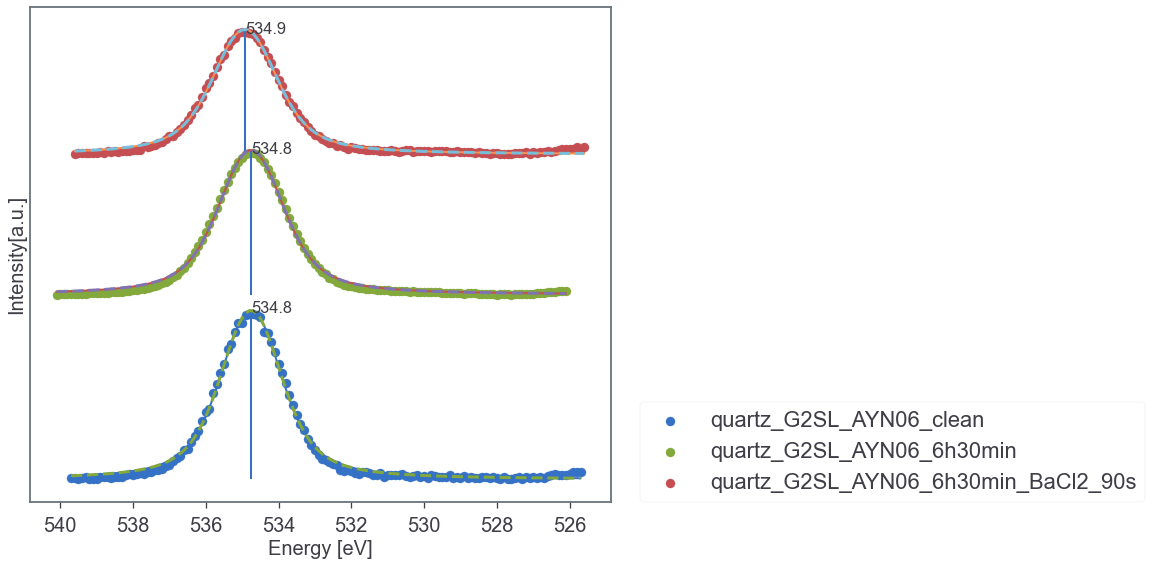

In [41]:
reg = 'O1s'
for i, xp in enumerate(bg[0:]):
    xf = XPFit(xp, reg)
    xf.voigt()
    plot_fit_result(xp, reg, offset =7*i)
    plt.gca().set(yticks = [], xlabel = 'Energy [eV]', ylabel = 'Intensity[a.u.]')
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

# Fit Carbon

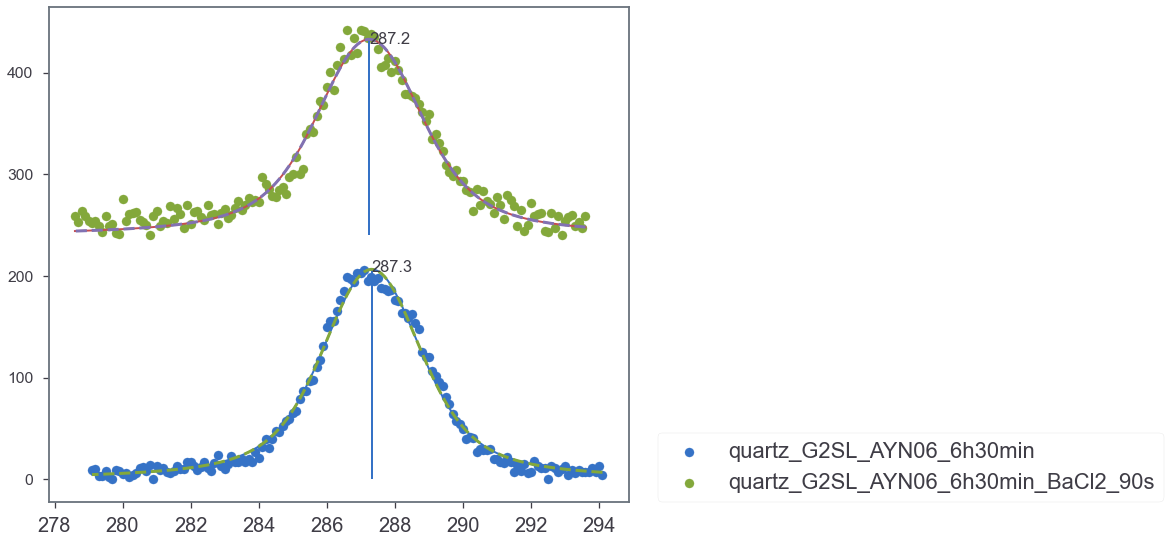

In [39]:
reg = 'C1s'
for i, xp in enumerate(bg[1:]):
    xf = XPFit(xp, reg)
    xf.voigt()
    plot_fit_result(xp, reg, offset =4*i)
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)

To calculate the Voigt components manually, we enter the parameters [(height), (centre), (width)], and their limits.

Modify user pars


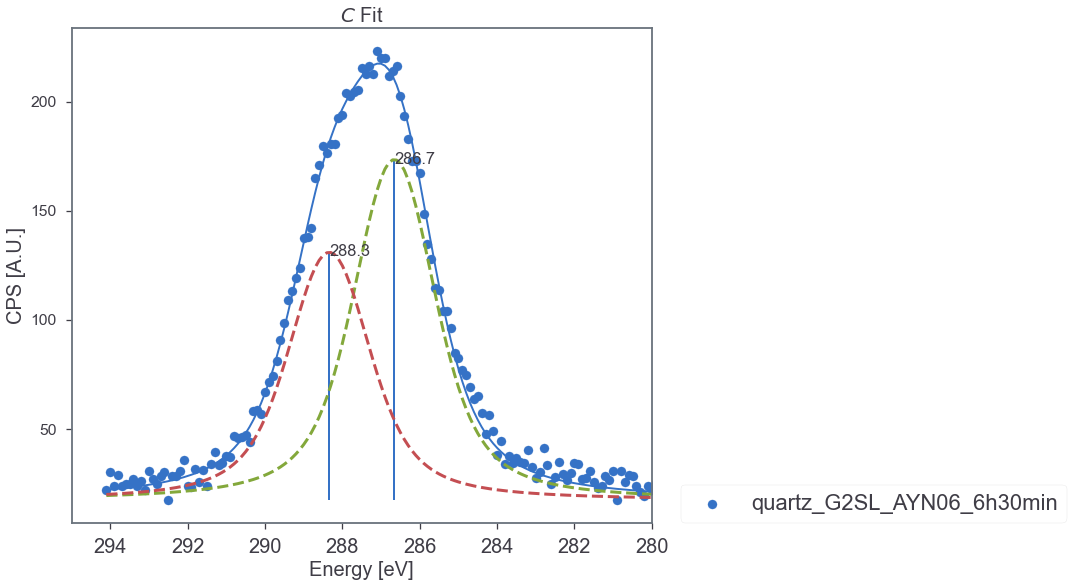

In [37]:
reg = 'C1s'
bg[1]

pars = [50, 285, 0.5] #parámetros [(altura), (centro), (ancho)]
bounds = [(100,500), (284, 286), (0.6,0.8)] #limites de los parámetros [(altura), (centro), (ancho)]

xf = XPFit(xp, reg)
#xf.voigt()
xf.preset_pars('v1_sigma', 0.7)
xf.preset_pars('v2_sigma', 0.7)

xf.double_voigt(286)
#xf.add_voigt(pars, bounds, )
plot_fit_result(xp, reg)
plt.gca().set(xlim =(295,280))
plt.gca().set(title='$C$ Fit')
plt.gca().set(xlabel = 'Energy [eV]', ylabel = 'CPS [A.U.]')
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)